# Demonstration of MuPT molecular representation for simple tripeptides

In [1]:
from networkx import path_graph
from rdkit import Chem
from rdkit.Chem.AllChem import Compute2DCoords

from mupt.geometry.shapes import PointCloud
from mupt.geometry.coordinates import origin
from mupt.mutils.iteration import sliding_window

from mupt.mupr.primitives import Primitive, PrimitiveHandle
from mupt.mupr.topology import TopologicalStructure

from mupt.interfaces.rdkit import primitive_from_rdkit
from mupt.chemistry.peptide import AMINO_ACIDS_BY_FASTA, AminoAcidSubstructure

Attempting to infer internal connections automatically from given topology; user should verify the connections assigned make sense!


Universe
└── Molecule


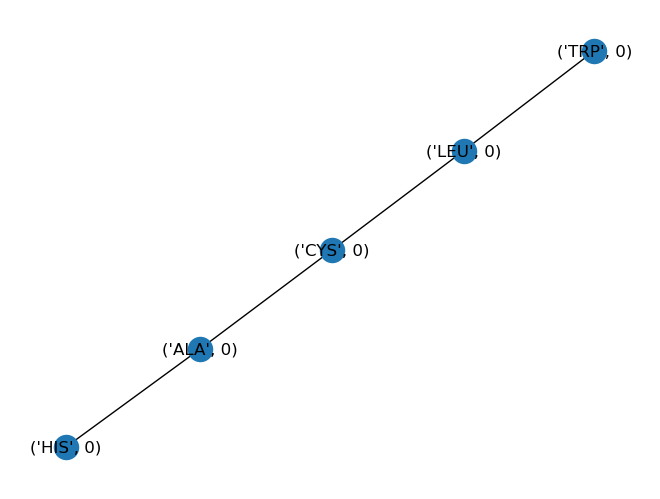

In [2]:
# sequence : str = 'WLC' #'AFCH'
sequence : str = 'WLCAH'

# assemble peptide molecule from amino acid fragments
peptide_prim = Primitive(
    shape=PointCloud(positions=origin(3)),
    label='Molecule',
)
frag_attrs : list[str] = ['fragment_term_N'] + ['fragment_middle']*(len(sequence)-2) + ['fragment_term_O']

path : list[PrimitiveHandle] = []
for frag_attr, letter in zip(frag_attrs, sequence):
    amino_acid : AminoAcidSubstructure = AMINO_ACIDS_BY_FASTA[letter]
    
    fragmol : Chem.Mol = getattr(amino_acid, frag_attr)()
    # DEV: temporary while more nuanced molecule sanitization settings get propagated throughout toolkit
    Chem.Kekulize(fragmol, clearAromaticFlags=True)
    Chem.SetAromaticity(fragmol, Chem.AROMATICITY_MDL)
    conf_id = Compute2DCoords(fragmol)
    # display(fragmol)
    
    resprim : Primitive = primitive_from_rdkit(fragmol, label=amino_acid.ccd_code, sanitize_frags=False, conformer_idx=conf_id)
    resprim.shape = PointCloud(positions=origin(3)) # represent spatially with single point for abstracted-view when plotting
    resprim_handle : PrimitiveHandle = peptide_prim.attach_child(resprim)
    path.append(resprim_handle)
    
peptide_prim.set_topology(path_graph(path, create_using=TopologicalStructure))

## align neighboring fragments
for (nb_handle1, nb_handle2) in sliding_window(path, 2):
    conn_handle1, conn_handle2 = peptide_prim.internal_connection_between(nb_handle1, nb_handle2)
    conn1 = peptide_prim.fetch_connector_on_child(nb_handle1, conn_handle1)
    conn2 = peptide_prim.fetch_connector_on_child(nb_handle2, conn_handle2)
    
    resprim2 = peptide_prim.fetch_child(nb_handle2)
    resprim2.rigidly_transform(conn2.rigid_antialignment_to(conn1))
    
# insert peptide molecule into universe
universe_prim = Primitive(
    shape=PointCloud(positions=origin(3)),
    label='Universe',
)
peptide_handle = universe_prim.attach_child(peptide_prim)

# visualize resulting hierarchy and topology
print(universe_prim.hierarchy_summary(to_depth=2))
peptide_prim.visualize_topology()

## Visualizing Primitive Hierarchy as a colorful diagram

In [3]:
from typing import Optional, Iterable
from itertools import tee

import matplotlib.pyplot as plt
%matplotlib ipympl
from mpl_toolkits.mplot3d import Axes3D

import numpy as np


def plot_pointlike_primitive(
    prim : Primitive,
    ax : plt.Axes,
    z_steps : Iterable[float],
    z_coord : float=0.0,
    z_eps : float=0.05,
    label : Optional[str]=None,
    default_color = 'b', # DEV: is it even worth it to try and put an acurate typehint (lots of types that can be interpreted as colors)
    plot_arrows : bool=False,
    arrow_color = 'grey',
) -> None:
    '''Plot a diagram of a Primitive hierarchy where every Primitive's shape is a single point'''
    delta_z_eps = np.array([0.0, 0.0, z_eps])
    if label is None:
        label = prim.label
    
    assert type(prim.shape) == PointCloud
    prim_pos = prim.shape.positions[0][:]
    prim_pos[-1] = z_coord

    ax.scatter(*prim_pos.T, marker='o', edgecolor='k', color=prim.metadata.get('color', default_color))
    ax.text(*(prim_pos + delta_z_eps), label, fontsize=12)
    
    if prim.has_children:
        z_step = next(z_steps)
        child_positions : dict[PrimitiveHandle, np.ndarray] = dict()
        
        # plot child primitive nodes
        for handle, childprim in prim.children_by_handle.items():
            child_pos = plot_pointlike_primitive(
                childprim,
                ax,
                z_coord=(z_coord - z_step),
                z_steps=tee(z_steps)[0], # need to tee to avoid sibling from exhausting next levels step
                z_eps=z_eps,
                label=(handle[1] if childprim.is_atom else handle[0]),
                default_color=default_color,
                plot_arrows=plot_arrows,
                arrow_color=arrow_color,
            )
            child_positions[handle] = child_pos
            if plot_arrows:
                ax.quiver(
                    *prim_pos,
                    *(child_pos - prim_pos),
                    color=arrow_color,
                    arrow_length_ratio=0.01,
                )
        
        # plot lateral edges in topologies
        for conn_ref1, conn_ref2 in prim.internal_connections:
            bond_positions = np.vstack([
                child_positions[conn_ref1.primitive_handle],
                child_positions[conn_ref2.primitive_handle],
            ])
            ax.plot(
                *bond_positions.T,
                color='k',
                linestyle='-',
            )
    return prim_pos

In [4]:
## configure drawing options here
scale : float = 10.0
cmap = plt.get_cmap('Accent')

z_gaps : tuple[float] = (1, 1, 1.2) # vertical gaps between hierarchy levels

plot_arrows : bool = True # False
arrow_color : str = 'grey'

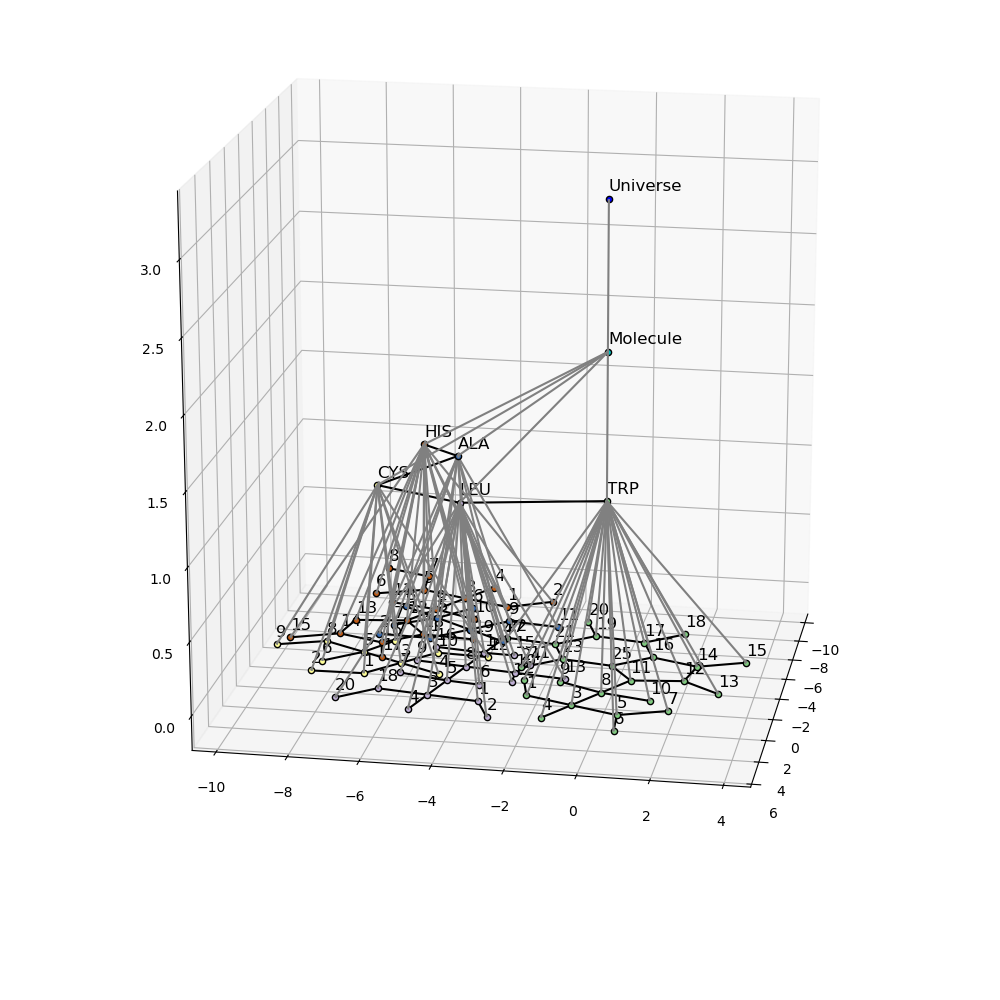

In [5]:
## set up axes
fig, ax = plt.subplots(1, 1, figsize=(scale, scale), subplot_kw={'projection': '3d'})
ax.grid(True) #False)
# ax.axis('off')

ax.autoscale('off')
ax.get_proj = lambda : np.dot(Axes3D.get_proj(ax), np.diag([1, 1.1, 1.5, 1]))

ax.elev = 18
ax.azim = 10
ax.roll = 0

## set colors within each primitive
universe_prim.metadata['color'] = 'b'
peptide_prim.metadata['color'] = 'c'

for i, resprim in enumerate(peptide_prim.children):
    rescolor = cmap(i / (len(peptide_prim.children)))
    resprim.metadata['color'] = rescolor
    for atomprim in resprim.children: # also color-code children correspondingly
        atomprim.metadata['color'] = rescolor
        
plot_pointlike_primitive(
    universe_prim,
    ax,
    z_coord=sum(z_gaps),
    z_steps=iter(z_gaps),
    plot_arrows=plot_arrows,
    arrow_color=arrow_color,
)
plt.show()